# Evaluation and Comparison on New Test Dataset

This notebook evaluates the performance of both our original and finetuned TB X-ray classification models on the new independent test dataset with detailed metrics and visualizations.

In [1]:
# Setup and Import Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

sys.path.append('..')
from attention_model import SimpleAttentionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Model Paths and Loading

In [2]:
# Define paths
ORIGINAL_MODEL_PATH = "../model/tb_chest_xray_attention_best.pt"
FINETUNED_MODEL_PATH = "../finetuning/tb_chest_xray_refined_20250318_034728.pt"
NEW_TEST_DATA_PATH = "../Testing/test_dataset"
METADATA_PATH = "../Testing/test_dataset/MetaData.csv"

# Check if the files and directories exist
print(f"Original model exists: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"Finetuned model exists: {os.path.exists(FINETUNED_MODEL_PATH)}")
print(f"New test dataset directory exists: {os.path.exists(NEW_TEST_DATA_PATH)}")
print(f"Metadata CSV exists: {os.path.exists(METADATA_PATH)}")

# Load model
def load_model(model_path):
    model = SimpleAttentionCNN().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Load both models
original_model = load_model(ORIGINAL_MODEL_PATH)
finetuned_model = load_model(FINETUNED_MODEL_PATH)

# Set models to evaluation mode
if original_model:
    original_model.eval()
if finetuned_model:
    finetuned_model.eval()

# Print available directories in the new test dataset folder to help with navigation
if os.path.exists(NEW_TEST_DATA_PATH):
    print(f"\nAvailable directories in new test dataset folder:")
    for item in os.listdir(NEW_TEST_DATA_PATH):
        if os.path.isdir(os.path.join(NEW_TEST_DATA_PATH, item)):
            print(f"  - {item}")

Original model exists: True
Finetuned model exists: True
New test dataset directory exists: True
Metadata CSV exists: True


C:\Users\dell\AppData\Local\Temp\ipykernel_23964\3867987569.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Successfully loaded model from ../model/tb_chest_xray_attention_best.pt
Successfully loaded model from ../finetuning/tb_chest_xray_refined_20250318_034728.pt

Available directories in new test dataset folder:
  - Chest-X-Ray


## 2. Load New Test Dataset

We'll load the new test dataset using information from the MetaData.csv.

In [3]:
def load_new_test_dataset():
    """Load the new test dataset from MetaData.csv"""
    metadata_csv = METADATA_PATH
    images_dir = os.path.join(NEW_TEST_DATA_PATH, "Chest-X-Ray", "image")
    
    if not os.path.isfile(metadata_csv):
        print(f"MetaData CSV not found: {metadata_csv}")
        return None, None
        
    if not os.path.isdir(images_dir):
        print(f"New test images directory not found: {images_dir}")
        # Try to find images directory by searching subdirectories
        base_dir = NEW_TEST_DATA_PATH
        for root, dirs, _ in os.walk(base_dir):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(potential_dir)):
                        images_dir = potential_dir
                        print(f"Found alternative images directory: {images_dir}")
                        break
            if os.path.isdir(images_dir) and 'image' in os.path.basename(images_dir).lower():
                break
        
        if not os.path.isdir(images_dir):
            return None, None
    
    try:
        # Read the CSV
        df = pd.read_csv(metadata_csv)
        
        # Extract data
        paths = []
        labels = []
        
        # Check file extensions in the directory to determine the correct one
        extensions = ['.png', '.jpg', '.jpeg']
        extension_check = None
        
        # Sample a file to check extension
        sample_files = os.listdir(images_dir)[:5]
        for file in sample_files:
            for ext in extensions:
                if file.lower().endswith(ext):
                    extension_check = ext
                    break
            if extension_check:
                break
        
        if not extension_check:
            extension_check = '.png'  # Default
        
        # Process each row in metadata
        for _, row in df.iterrows():
            id_val = str(row['id'])
            label = int(row['ptb'])  # ptb=1 is TB positive, ptb=0 is Normal
            
            # Check for matching image file
            img_filename = f"{id_val}{extension_check}"
            img_path = os.path.join(images_dir, img_filename)
            
            # If direct match not found, try searching
            if not os.path.isfile(img_path):
                for file in os.listdir(images_dir):
                    if id_val in file and file.lower().endswith(tuple(extensions)):
                        img_path = os.path.join(images_dir, file)
                        break
            
            if os.path.isfile(img_path):
                paths.append(img_path)
                labels.append(label)
        
        print(f"Loaded {len(paths)} new test images")
        if len(labels) > 0:
            print(f"Class distribution: {labels.count(0)} Normal, {labels.count(1)} TB")
        
        return paths, labels
    
    except Exception as e:
        print(f"Error loading new test data: {e}")
        return None, None

# Load new test dataset
new_test_paths, new_test_labels = load_new_test_dataset()

if new_test_paths is None:
    print("Failed to load new test dataset!")

Loaded 704 new test images
Class distribution: 359 Normal, 345 TB


## 3. Prepare New Test Dataset for Testing

In [4]:
class NewTestDataset(Dataset):
    """Dataset class for the new test images."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Read the image
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                raise FileNotFoundError(f"Could not read image: {img_path}")
            
            # Convert to PIL for transforms
            pil_img = Image.fromarray(img_gray, mode='L')
            img_tensor = self.transform(pil_img)
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), img_path
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Return empty tensor with same shape
            return torch.zeros(1, 256, 256), torch.tensor(label, dtype=torch.float32), img_path

# Create dataset and dataloader for the new test data
if new_test_paths is not None and len(new_test_paths) > 0:
    # Define transforms that match the original model's preprocessing
    test_transforms = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    
    new_test_dataset = NewTestDataset(new_test_paths, new_test_labels, transform=test_transforms)
    new_test_dataloader = DataLoader(new_test_dataset, batch_size=16, shuffle=False)
    
    print(f"Created new test dataset with {len(new_test_dataset)} images")
else:
    print("Could not create new test dataset!")

Created new test dataset with 704 images


## 4. Model Evaluation Functions

In [5]:
def evaluate_model(model, dataloader, model_name="Model"):
    """Evaluate model and calculate all metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_attn_maps = []
    all_img_paths = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, labels, paths = batch
            images = images.to(device)
            
            # Forward pass
            outputs, attention_maps = model(images)
            
            # Get predictions
            probs = outputs.cpu().numpy().flatten()
            preds = (outputs >= 0.5).cpu().numpy().flatten().astype(int)
            
            # Store results
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            all_attn_maps.extend([attn.cpu().numpy() for attn in attention_maps])
            all_img_paths.extend(paths)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Print metrics
    print(f"\n--- {model_name} Performance Metrics on New Test Dataset ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    results = {
        'preds': all_preds,
        'labels': all_labels,
        'probs': all_probs,
        'attention_maps': all_attn_maps,
        'image_paths': all_img_paths,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'confusion_matrix': cm
        }
    }
    
    return results

## 5. Evaluate Both Models on New Test Dataset

In [6]:
# Run evaluation for both models on new test data
model_results = {}

if 'new_test_dataloader' in locals() and original_model:
    print("Evaluating original model on new test dataset...")
    model_results['original'] = evaluate_model(original_model, new_test_dataloader, "Original Model")
else:
    print("Original model or new test data not available. Cannot evaluate.")

if 'new_test_dataloader' in locals() and finetuned_model:
    print("\nEvaluating finetuned model on new test dataset...")
    model_results['finetuned'] = evaluate_model(finetuned_model, new_test_dataloader, "Finetuned Model")
else:
    print("Finetuned model or new test data not available. Cannot evaluate.")

Evaluating original model on new test dataset...

--- Original Model Performance Metrics on New Test Dataset ---
Accuracy: 0.5156
Precision: 0.5048
Recall: 0.6145
F1 Score: 0.5542
AUC-ROC: 0.5132
Confusion Matrix:
[[151 208]
 [133 212]]

Evaluating finetuned model on new test dataset...

--- Finetuned Model Performance Metrics on New Test Dataset ---
Accuracy: 0.6932
Precision: 0.7129
Recall: 0.6261
F1 Score: 0.6667
AUC-ROC: 0.7765
Confusion Matrix:
[[272  87]
 [129 216]]


## 6. Visualization of Results

In [7]:
def visualize_confusion_matrix(cm, class_names=['Normal', 'Tuberculosis'], title='Confusion Matrix'):
    """Visualize confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results_dict):
    """Plot ROC curves for multiple models on same graph."""
    plt.figure(figsize=(10, 7))
    
    colors = {'original': 'blue', 'finetuned': 'red'}
    labels = {'original': 'Original Model', 'finetuned': 'Finetuned Model'}
    
    for model_name, results in results_dict.items():
        if model_name in results_dict:
            fpr = results['metrics']['fpr']
            tpr = results['metrics']['tpr']
            roc_auc = results['metrics']['auc']
            color = colors.get(model_name, 'green')
            label = labels.get(model_name, model_name)
            plt.plot(fpr, tpr, color=color, lw=2,
                     label=f'{label} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison on New Test Dataset')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_comparative_metrics_bar_chart(results_dict):
    """Create side-by-side bar chart comparing metrics between models."""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    
    # Extract metrics for each model
    metrics_values = {}
    for model_name, results in results_dict.items():
        metrics_values[model_name] = [results['metrics'][metric] for metric in metrics_to_plot]
    
    # Create bar chart
    plt.figure(figsize=(14, 7))
    
    # Set width of bars
    bar_width = 0.35
    index = np.arange(len(metric_labels))
    
    # Create bars
    if 'original' in metrics_values:
        plt.bar(index - bar_width/2, metrics_values['original'], bar_width, 
                label='Original Model', color='cornflowerblue', alpha=0.8)
        
        # Add text labels for original model
        for i, v in enumerate(metrics_values['original']):
            plt.text(i - bar_width/2 - 0.05, v + 0.01, f'{v:.3f}', 
                    color='navy', fontweight='bold', fontsize=9)
    
    if 'finetuned' in metrics_values:
        plt.bar(index + bar_width/2, metrics_values['finetuned'], bar_width,
                label='Finetuned Model', color='lightcoral', alpha=0.8)
        
        # Add text labels for finetuned model
        for i, v in enumerate(metrics_values['finetuned']):
            plt.text(i + bar_width/2 - 0.05, v + 0.01, f'{v:.3f}',
                    color='darkred', fontweight='bold', fontsize=9)
    
    plt.ylabel('Score')
    plt.title('Model Performance Comparison on New Test Dataset')
    plt.xticks(index, metric_labels)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


--- Confusion Matrix Visualizations ---


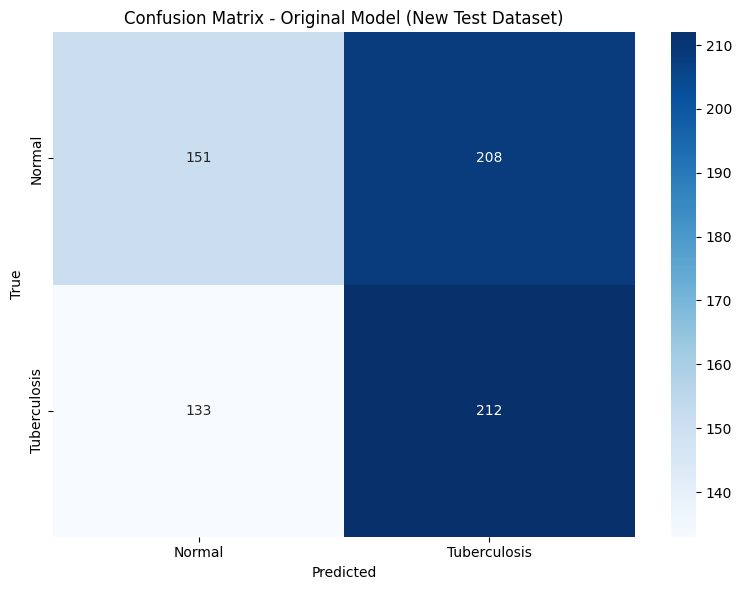

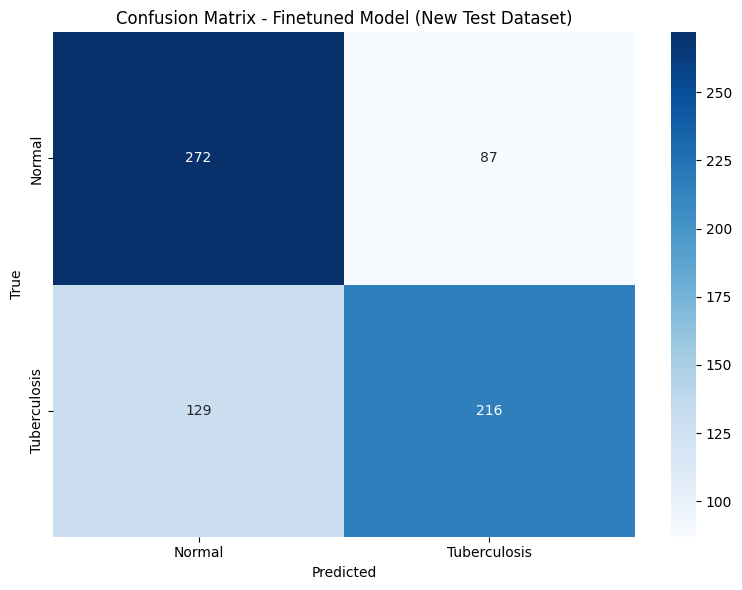


--- ROC Curves Comparison ---


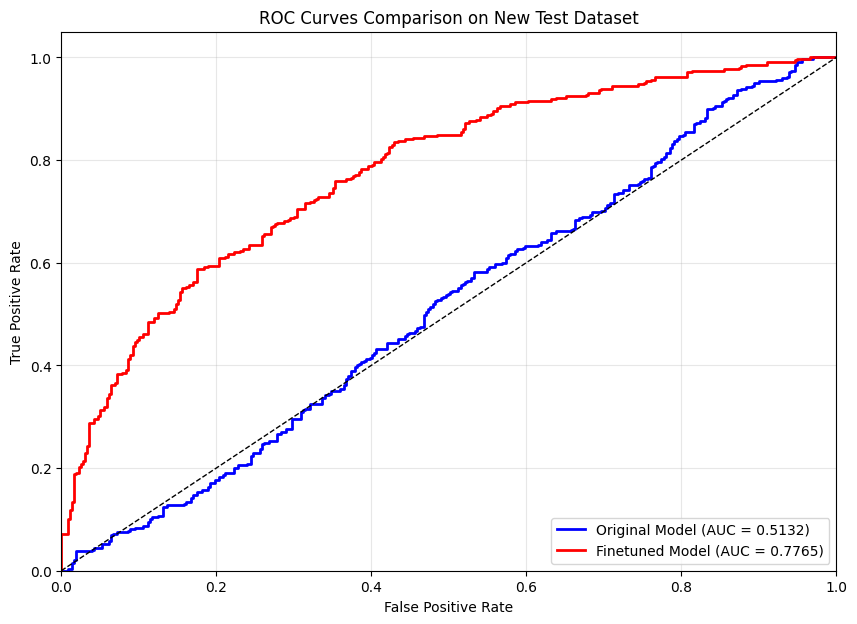


--- Performance Metrics Comparison ---


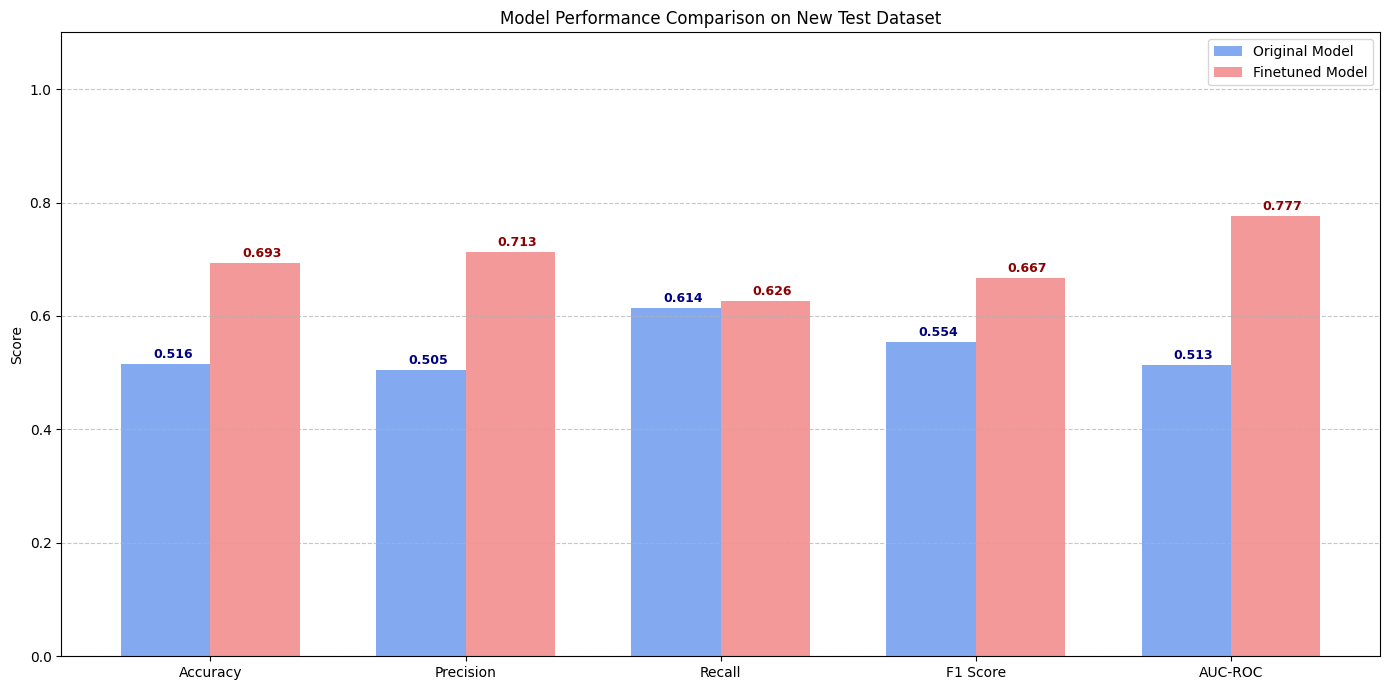

In [8]:
# Visualize results for both models
if len(model_results) > 0:
    # 1. Visualize Confusion Matrices for both models
    print("\n--- Confusion Matrix Visualizations ---")
    
    if 'original' in model_results:
        visualize_confusion_matrix(
            model_results['original']['metrics']['confusion_matrix'],
            title='Confusion Matrix - Original Model (New Test Dataset)'
        )
    
    if 'finetuned' in model_results:
        visualize_confusion_matrix(
            model_results['finetuned']['metrics']['confusion_matrix'],
            title='Confusion Matrix - Finetuned Model (New Test Dataset)'
        )
    
    # 2. Plot comparative ROC Curve
    print("\n--- ROC Curves Comparison ---")
    plot_roc_curves(model_results)
    
    # 3. Plot comparative bar chart of metrics
    print("\n--- Performance Metrics Comparison ---")
    plot_comparative_metrics_bar_chart(model_results)

## 7. Analysis of Prediction Differences

In [9]:
def compare_predictions(results_dict):
    """Compare prediction differences between models."""
    if 'original' not in results_dict or 'finetuned' not in results_dict:
        print("Need both models to compare predictions.")
        return
        
    orig_preds = results_dict['original']['preds']
    ft_preds = results_dict['finetuned']['preds']
    labels = results_dict['original']['labels']  # Labels are the same for both models
    img_paths = results_dict['original']['image_paths']
    
    # Find indices where models differ in predictions
    diff_indices = [i for i in range(len(orig_preds)) if orig_preds[i] != ft_preds[i]]
    
    # Classification of differences
    improved = [i for i in diff_indices if ft_preds[i] == labels[i] and orig_preds[i] != labels[i]]
    worsened = [i for i in diff_indices if ft_preds[i] != labels[i] and orig_preds[i] == labels[i]]
    
    print(f"Total new test samples: {len(orig_preds)}")
    print(f"Samples where models predict differently: {len(diff_indices)}")
    print(f"Improvements (finetuned correct, original wrong): {len(improved)}")
    print(f"Regressions (finetuned wrong, original correct): {len(worsened)}")
    
    # Display examples of improvements
    if improved:
        print("\nExamples of improvements in new test dataset:")
        plt.figure(figsize=(15, 4*min(3, len(improved))))
        
        for i, idx in enumerate(improved[:min(3, len(improved))]):
            img_path = img_paths[idx]
            true_label = "Tuberculosis" if labels[idx] == 1 else "Normal"
            orig_pred = "Tuberculosis" if orig_preds[idx] == 1 else "Normal"
            ft_pred = "Tuberculosis" if ft_preds[idx] == 1 else "Normal"
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.subplot(min(3, len(improved)), 1, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"True: {true_label}, Original: {orig_pred}, Finetuned: {ft_pred}\nFile: {os.path.basename(img_path)}")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Display examples of regressions
    if worsened:
        print("\nExamples of regressions in new test dataset:")
        plt.figure(figsize=(15, 4*min(3, len(worsened))))
        
        for i, idx in enumerate(worsened[:min(3, len(worsened))]):
            img_path = img_paths[idx]
            true_label = "Tuberculosis" if labels[idx] == 1 else "Normal"
            orig_pred = "Tuberculosis" if orig_preds[idx] == 1 else "Normal"
            ft_pred = "Tuberculosis" if ft_preds[idx] == 1 else "Normal"
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.subplot(min(3, len(worsened)), 1, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"True: {true_label}, Original: {orig_pred}, Finetuned: {ft_pred}\nFile: {os.path.basename(img_path)}")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()


--- Prediction Analysis on New Test Dataset ---
Total new test samples: 704
Samples where models predict differently: 277
Improvements (finetuned correct, original wrong): 201
Regressions (finetuned wrong, original correct): 76

Examples of improvements in new test dataset:


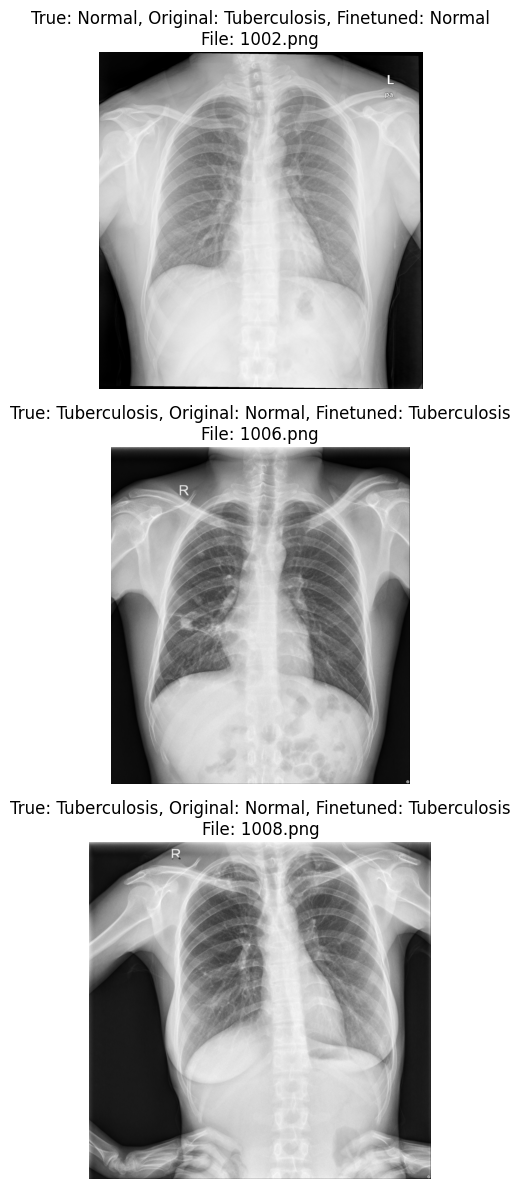


Examples of regressions in new test dataset:


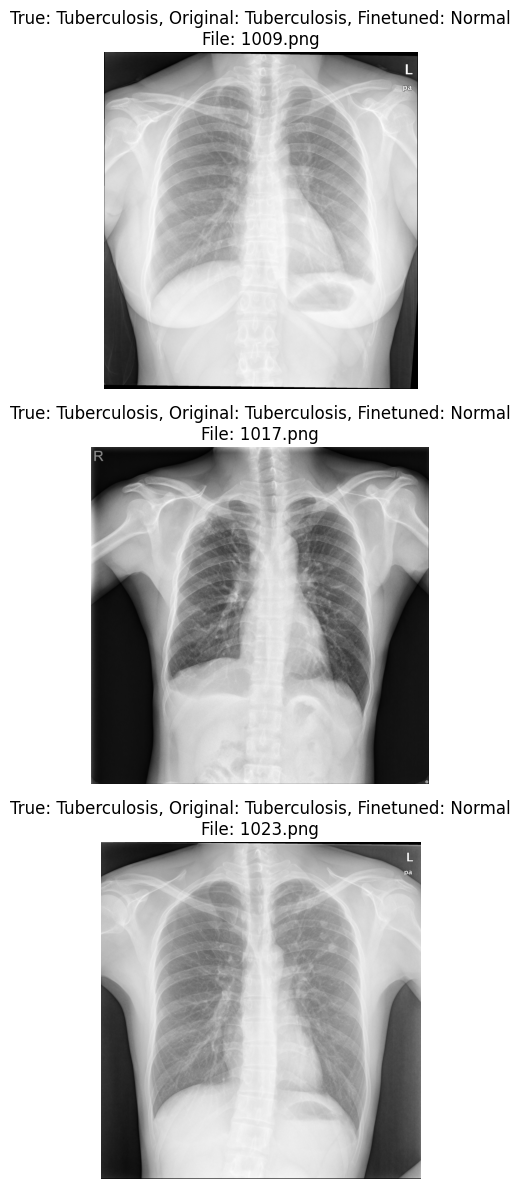

In [10]:
# Compare predictions between models on the new test dataset
if 'original' in model_results and 'finetuned' in model_results:
    print("\n--- Prediction Analysis on New Test Dataset ---")
    compare_predictions(model_results)
else:
    print("\nNeed both models to compare predictions.")

## 8. Detailed Classification Reports

In [11]:
# Generate classification reports for both models
if 'original' in model_results:
    # Original model report
    print("\n--- Original Model Classification Report (New Test Dataset) ---")
    orig_report = classification_report(
        model_results['original']['labels'], 
        model_results['original']['preds'],
        target_names=['Normal', 'Tuberculosis']
    )
    print(orig_report)
    
    # Create DataFrame for better visualization
    orig_report_dict = classification_report(
        model_results['original']['labels'],
        model_results['original']['preds'],
        target_names=['Normal', 'Tuberculosis'],
        output_dict=True
    )
    print("Original Model:")
    display(pd.DataFrame(orig_report_dict).transpose().round(4))

if 'finetuned' in model_results:
    # Finetuned model report
    print("\n--- Finetuned Model Classification Report (New Test Dataset) ---")
    ft_report = classification_report(
        model_results['finetuned']['labels'], 
        model_results['finetuned']['preds'],
        target_names=['Normal', 'Tuberculosis']
    )
    print(ft_report)
    
    # Create DataFrame for better visualization
    ft_report_dict = classification_report(
        model_results['finetuned']['labels'],
        model_results['finetuned']['preds'],
        target_names=['Normal', 'Tuberculosis'],
        output_dict=True
    )
    print("Finetuned Model:")
    display(pd.DataFrame(ft_report_dict).transpose().round(4))


--- Original Model Classification Report (New Test Dataset) ---
              precision    recall  f1-score   support

      Normal       0.53      0.42      0.47       359
Tuberculosis       0.50      0.61      0.55       345

    accuracy                           0.52       704
   macro avg       0.52      0.52      0.51       704
weighted avg       0.52      0.52      0.51       704

Original Model:


,precision,recall,f1-score,support
Normal,0.5317,0.4206,0.4697,359.0000
Tuberculosis,0.5048,0.6145,0.5542,345.0000
accuracy,0.5156,0.5156,0.5156,0.5156
macro avg,0.5182,0.5176,0.5120,704.0000
weighted avg,0.5185,0.5156,0.5111,704.0000



--- Finetuned Model Classification Report (New Test Dataset) ---
              precision    recall  f1-score   support

      Normal       0.68      0.76      0.72       359
Tuberculosis       0.71      0.63      0.67       345

    accuracy                           0.69       704
   macro avg       0.70      0.69      0.69       704
weighted avg       0.70      0.69      0.69       704

Finetuned Model:


,precision,recall,f1-score,support
Normal,0.6783,0.7577,0.7158,359.0000
Tuberculosis,0.7129,0.6261,0.6667,345.0000
accuracy,0.6932,0.6932,0.6932,0.6932
macro avg,0.6956,0.6919,0.6912,704.0000
weighted avg,0.6952,0.6932,0.6917,704.0000
